In [1]:
import numpy as np
import random
import types
import pandas as pd
import numpy as np
from functools import partial
import time
import os
import seaborn as sns
import pickle
import glob
from matplotlib import cm
import matplotlib
from sklearn.linear_model import LinearRegression
from IPython.display import display, HTML
import random
from groupBMC.groupBMC import GroupBMC
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
### Select dataset
compiled_datadir='compiled_data'
dataset_name='dev'

## Load data
data_file=os.path.join(compiled_datadir,dataset_name, 'dataset.pkl')
#
df_full=pd.read_pickle(data_file)

# Load metadata
metadata_file=os.path.join(compiled_datadir,dataset_name, 'metadata.pkl')
with open(metadata_file, 'rb') as file:
    metadata = pickle.load(file)


fit_folder='./model_fits/basic_modelspace_bads_it250_funit500_nres5_resetall/'

fit_prefixes = ''
    
pre_filelist=glob.glob(os.path.join(fit_folder,fit_prefixes+"*.pkl"))
fit_filelist = [file for file in pre_filelist if not file.endswith("_info.pkl")]
info_filelist = [file for file in pre_filelist if file.endswith("_info.pkl")]


results_list=[]

compared_models=['SASonly', 'SASSS_Omega_standard'] #+'Q_Go_V_pers_cntFull'
selected_model='SASSS_Omega_standard'

#compared_models=['Q', 'Q_Go', 'Q_V', 'Q_Go_V', 'Q_Go_V_pers','Q_Go_V_pers_cntCV_arbCV'] #+'Q_Go_V_pers_cntFull'

targets_only=True # helper for dir approach

model_names=[]
initial_order=[]

loadMode='dir' # dir or targets


if loadMode=='dir':

    for i, filepath in enumerate(fit_filelist):
        
        model_name = os.path.basename(filepath[0:-4])
        if targets_only and not np.isin(model_name,compared_models):
          continue
        initial_order.append(model_name)
        fitdata_file=os.path.join(filepath)
        batchdf=pd.read_pickle(fitdata_file)
        batchdf = batchdf.sort_values(by='fitId', ascending=True).reset_index(drop=True)
        for fitId in range(len(batchdf)):
          batchdf.loc[fitId,'fitMemory']['fitId']=fitId
          
        results_list.append(batchdf)
        
elif  loadMode=='targets':
        
    for i, name in enumerate(compared_models):
        filepath = os.path.join(fit_folder,fit_prefixes+compared_models[i]+".pkl")
        if os.path.exists(filepath):
            batchdf=pd.read_pickle(filepath)
            batchdf = batchdf.sort_values(by='fitId', ascending=True).reset_index(drop=True)
            for fitId in range(len(batchdf)):
              batchdf.loc[fitId,'fitMemory']['fitId']=fitId
            results_list.append(batchdf)
            initial_order.append(compared_models[i])
        else:
            raise Exception(compared_models[i] +f' not found in {fit_folder+fit_prefixes}. Remove from the list.')
    
if targets_only and loadMode=='dir':
  reordered_results=[]
  for initname in initial_order:
    if np.isin(initname,compared_models):
      reordered_results.append(results_list[initial_order.index(initname)])
  results_df=pd.concat(reordered_results,axis=0)
  print('here')
elif loadMode=='dir':
  reordering_vec=[]
  for initname in initial_order:
    reordering_vec.append(len(initname))
  reordering_vec=np.argsort(reordering_vec)
  reordered_results=[results_list[reordering_vec[i]] for i in range(len(reordering_vec))]
  results_df=pd.concat(reordered_results,axis=0)
  compared_models=[initial_order[reordering_vec[i]] for i in range(len(reordering_vec))]
else:
  results_df=pd.concat(results_list,axis=0)

results_df.reset_index(drop=True, inplace=True)


here


In [3]:
criterion = 'bestAIC'
group_df = results_df.groupby(['fitAgent'])[criterion].mean().reset_index()
if targets_only or loadMode=='targets':
  group_df = group_df.set_index("fitAgent").loc[compared_models].reset_index()
else:
  group_df = group_df.sort_values(by="fitAgent", key=lambda x: x.str.len()).reset_index()

# get definitive model order
model_names=group_df['fitAgent'].to_list()

#
pivot_df = results_df.pivot(columns='fitAgent', index='fitId',  values=criterion).reset_index()
pivot_df=pivot_df[model_names]
result = GroupBMC(-pivot_df.T.values*0.5).get_result()

#
pd.set_option('display.max_colwidth', None)
group_df['freq']=result.frequency_mean
group_df['ep']=result.exceedance_probability
display(group_df)
print(f'Highest exceedance probability: {group_df["fitAgent"].values[np.argmax(result.exceedance_probability)]} ({np.max(result.exceedance_probability):.2f})')

,fitAgent,bestAIC,freq,ep
0,SASonly,229.316978,0.187612,0.091912
1,SASSS_Omega_standard,227.144308,0.812388,0.908088


Highest exceedance probability: SASSS_Omega_standard (0.91)


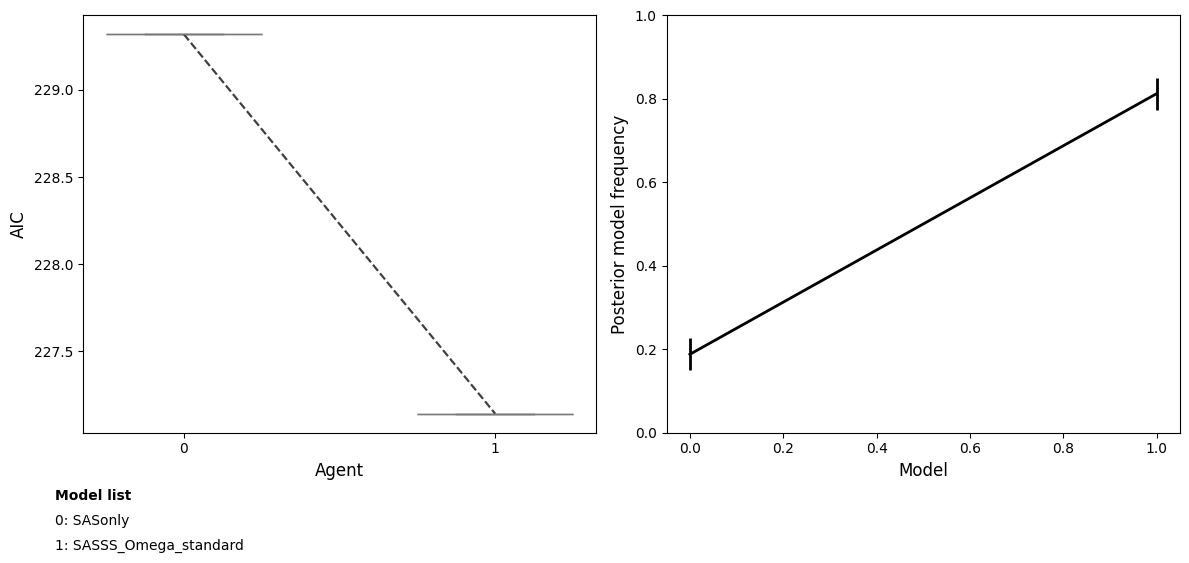

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))


sns.boxplot(x='fitAgent', hue='fitAgent', order=compared_models, y=criterion, data=results_df, width=0.5, palette='Pastel1', ax=axes[0])
sns.lineplot(x='fitAgent',  y=criterion, data=results_df, style='fitId', dashes=False, color='black',linestyle='--', alpha=0.5, ax=axes[0], legend=False)

axes[0].set_xlabel('Agent', fontsize=12)
axes[0].set_ylabel(criterion[4:], fontsize=12)
axes[0].set_xticks(np.arange(0,len(model_names),1))
axes[0].set_xticklabels(np.arange(0,len(model_names),1))  # Option 1: Setting empty labels
plt.ylabel(criterion[4:], fontsize=12)
plt.grid(False)

# Show plot with adjustments



axes[1].errorbar(np.arange(0,pivot_df.shape[1],1), result.frequency_mean, result.frequency_var, linewidth=2, color='black')
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('Posterior model frequency', fontsize=12)

start_y=-0.01
delta_y=-0.05
plt.figtext(0.05, start_y, 'Model list', ha="left", fontsize=10, weight='bold')
start_y=start_y+delta_y
for m, modname in enumerate(model_names):
    plt.figtext(0.05, start_y, f'{m}: {model_names[m]}', ha="left", fontsize=10)
    start_y=start_y+delta_y
#plt.figtext(0.5, -0.15, "Another line of text.", ha="center", fontsize=10)

plt.tight_layout()
plt.show()



In [ ]:
# augment the dataset with model-based regressors
df_full_augmented=pd.DataFrame()

fitMemory=results_df.loc[results_df.loc[:,'fitAgent']==selected_model,'fitMemory'].to_list()

for pix, pid in enumerate(metadata['included_participants']):
  
  df_subdata=pd.concat([df_full.loc[df_full['participant']==pid,:].reset_index(drop=True),  fitMemory[pix].reset_index(drop=True)],axis=1).reset_index(drop=True)
  
  df_subdata['SSPE']=np.insert(df_subdata['SSPE'].values[0:-1],0,np.nan)
  df_subdata['SASPE']=np.insert(df_subdata['SASPE'].values[0:-1],0,np.nan)
  df_subdata['OmegaPE']=np.insert(df_subdata['OmegaPE'].values[0:-1],0,np.nan)
  
  df_full_augmented=pd.concat([df_full_augmented,df_subdata],axis=0,ignore_index=True).reset_index(drop=True)

augmented_data_file=os.path.join(compiled_datadir,dataset_name, f'dataset_{selected_model}.pkl')
augmented_data_file_csv=os.path.join(compiled_datadir,dataset_name, f'dataset_{selected_model}.csv')
df_full_augmented.to_pickle(augmented_data_file)
df_full_augmented.to_csv(augmented_data_file_csv)